<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
import torch.optim as optim


## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** как я понимаю `batch_size` это то сколько примеров модель получает во время обучения, если он будет маленьким, то будет происходить много иттераций, которые замедлят работу, достаточно большое - все будет проходить достаточно резво. Но слишком большое число может повлиять на качество, так как будет происходить менее точное обучение

Посмотрим на какую-нибудь картинку:

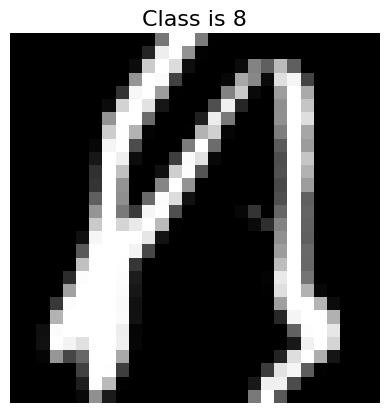

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





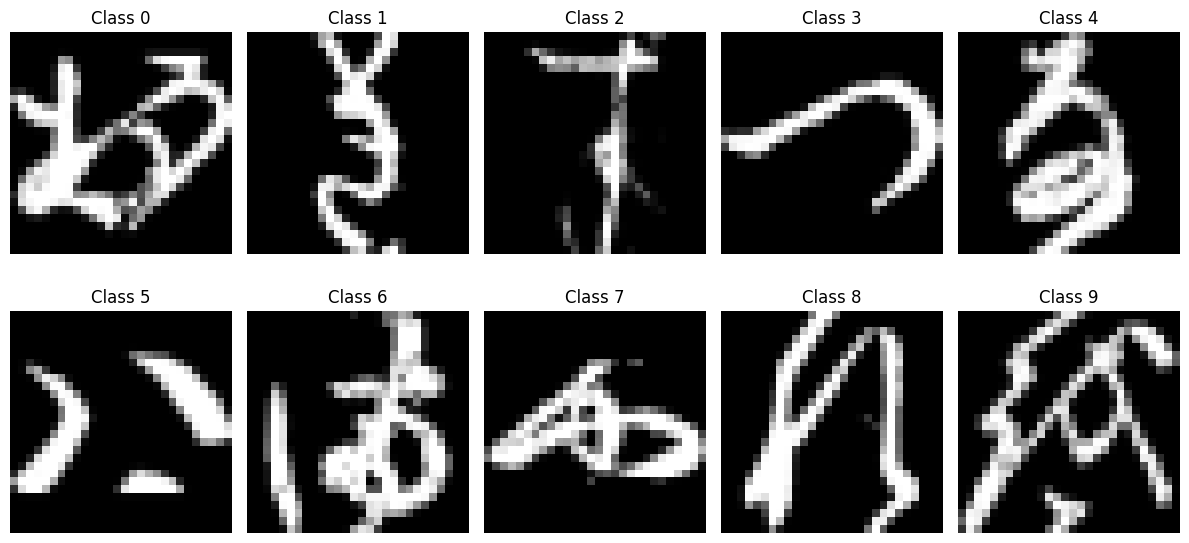

In [5]:
kmnist_train_images = trainset.data.numpy()
kmnist_train_labels = trainset.targets.numpy()
# Создание фигуры и осей графика
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axs = axs.flatten()

# Отображение изображений каждого класса на графике
for i in range(10):
    img = kmnist_train_images[kmnist_train_labels == i][0]
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(f"Class {i}")
    axs[i].axis("off")

# Отображение графика
plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [6]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 784) # превращаем картинку в вектор
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [52]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation

    def forward(self, x): 
        x = x.view(-1, 784) 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        logits = self.fc3(x)
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

> * слой 1  784 * 256 = 200,704 веса и 256 смещений
> * слой 2 содержит 256 * 128 = 32,768 веса и 128 смещений
> * слой 3 содержит 128 * 10 = 1280 веса и 10 смещений


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [8]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [9]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [10]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad() # Обнуляем градиенты
        outputs = fc_net(images) # Прогоняем данные через сеть и получаем предсказания
        loss = loss_function(outputs, labels) # Рассчитываем функцию потерь
        loss.backward() # Рассчитываем градиенты
        optimizer.step() # Обновляем веса
    train_accuracy = get_accuracy(fc_net, trainloader)
    test_accuracy = get_accuracy(fc_net, testloader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

final_test_accuracy = get_accuracy(fc_net, testloader)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch 1/10, Train Accuracy: 0.8463, Test Accuracy: 0.7129
Epoch 2/10, Train Accuracy: 0.8857, Test Accuracy: 0.7639
Epoch 3/10, Train Accuracy: 0.9043, Test Accuracy: 0.7905
Epoch 4/10, Train Accuracy: 0.9211, Test Accuracy: 0.8106
Epoch 5/10, Train Accuracy: 0.9333, Test Accuracy: 0.8305
Epoch 6/10, Train Accuracy: 0.9429, Test Accuracy: 0.8379
Epoch 7/10, Train Accuracy: 0.9515, Test Accuracy: 0.8546
Epoch 8/10, Train Accuracy: 0.9583, Test Accuracy: 0.8596
Epoch 9/10, Train Accuracy: 0.9650, Test Accuracy: 0.8642
Epoch 10/10, Train Accuracy: 0.9698, Test Accuracy: 0.8676
Final Test Accuracy: 0.8676


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [11]:
# вычисляем среднее значение и стандартное отклонение всех пикселей в тренировочном наборе данных
mean = 0.
std = 0.
total_images = 0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.1918])
Std: tensor([0.3385])


In [12]:
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

tensor([0.1918]) tensor([0.3385])


In [13]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [14]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad() # Обнуляем градиенты
        outputs = fc_net(images) # Прогоняем данные через сеть и получаем предсказания
        loss = loss_function(outputs, labels) # Рассчитываем функцию потерь
        loss.backward() # Рассчитываем градиенты
        optimizer.step() # Обновляем веса
    # Метрики после каждой эпохи
    train_accuracy = get_accuracy(fc_net, trainloader)
    test_accuracy = get_accuracy(fc_net, testloader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

final_test_accuracy = get_accuracy(fc_net, testloader)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch 1/10, Train Accuracy: 0.8927, Test Accuracy: 0.7776
Epoch 2/10, Train Accuracy: 0.9312, Test Accuracy: 0.8234
Epoch 3/10, Train Accuracy: 0.9487, Test Accuracy: 0.8490
Epoch 4/10, Train Accuracy: 0.9603, Test Accuracy: 0.8663
Epoch 5/10, Train Accuracy: 0.9698, Test Accuracy: 0.8824
Epoch 6/10, Train Accuracy: 0.9781, Test Accuracy: 0.8865
Epoch 7/10, Train Accuracy: 0.9824, Test Accuracy: 0.8864
Epoch 8/10, Train Accuracy: 0.9852, Test Accuracy: 0.8948
Epoch 9/10, Train Accuracy: 0.9891, Test Accuracy: 0.8948
Epoch 10/10, Train Accuracy: 0.9917, Test Accuracy: 0.8999
Final Test Accuracy: 0.8999


Как изменилась `accuracy` после нормализации?

Нуууу


### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [22]:
## YOUR CODE HERE

sigmoid_net = FCNet(activation=F.sigmoid)
gelu_net = FCNet(activation=F.gelu)
tanh_net = FCNet(activation=F.tanh)


def train(net, trainloader, n_epochs):
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
    loss_history = []
    for epoch in range(n_epochs):
        for images, labels in trainloader:
            optimizer.zero_grad() # Обнуляем градиенты
            outputs = net(images) # Прогоняем данные через сеть и получаем предсказания
            loss = loss_function(outputs, labels) # Рассчитываем функцию потерь
            loss.backward() # Рассчитываем градиенты
            optimizer.step() # Обновляем веса
    # Метрики после каждой эпохи
    train_accuracy = get_accuracy(net, trainloader)
    test_accuracy = get_accuracy(net, testloader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

sigmoid_loss_hist = train(sigmoid_net, trainloader, n_epochs)
gelu_loss_hist = train(gelu_net, trainloader, n_epochs)
tanh_loss_hist = train(tanh_net, trainloader, n_epochs)

Epoch 10/10, Train Accuracy: 0.9585, Test Accuracy: 0.8555
Epoch 10/10, Train Accuracy: 0.9951, Test Accuracy: 0.9005
Epoch 10/10, Train Accuracy: 0.9969, Test Accuracy: 0.8967


In [21]:
sigmoid_acc = get_accuracy(sigmoid_net, testloader)
gelu_acc = get_accuracy(gelu_net, testloader)
tanh_acc = get_accuracy(tanh_net, testloader)

print("Accuracy with Sigmoid activation:", sigmoid_acc)
print("Accuracy with GELU activation:", gelu_acc)
print("Accuracy with Tanh activation:", tanh_acc)

Accuracy with Sigmoid activation: 0.8585
Accuracy with GELU activation: 0.8964
Accuracy with Tanh activation: 0.899


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Tanh вроде ничего

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [27]:
tanh_net = FCNet(activation=F.tanh)
n_epochs = 10

def train(net, trainloader, optimizer, n_epochs):
    loss_function = nn.CrossEntropyLoss()
    loss_history = []
    for epoch in range(n_epochs):
        for images, labels in trainloader:
            optimizer.zero_grad() # Обнуляем градиенты
            outputs = net(images) # Прогоняем данные через сеть и получаем предсказания
            loss = loss_function(outputs, labels) # Рассчитываем функцию потерь
            loss.backward() # Рассчитываем градиенты
            optimizer.step()
            
# Создаем три сети с разными методами оптимизации
adam_net = FCNet(activation=F.tanh)
rmsprop_net = FCNet(activation=F.tanh)
adagrad_net = FCNet(activation=F.tanh)

# Создаем три оптимизатора с разными методами оптимизации
adam_optimizer = optim.Adam(adam_net.parameters(), lr=3e-4)
rmsprop_optimizer = optim.RMSprop(rmsprop_net.parameters(), lr=3e-4)
adagrad_optimizer = optim.Adagrad(adagrad_net.parameters(), lr=3e-4)

# Обучаем каждую сеть с соответствующим оптимизатором
adam_loss_history = train(adam_net, trainloader, adam_optimizer, n_epochs=10)
rmsprop_loss_history = train(rmsprop_net, trainloader, rmsprop_optimizer, n_epochs=10)
adagrad_loss_history = train(adagrad_net, trainloader, adagrad_optimizer, n_epochs=10)

# Сравниваем перформанс каждой сети
adam_train_accuracy = get_accuracy(adam_net, trainloader)
rmsprop_train_accuracy = get_accuracy(rmsprop_net, trainloader)
adagrad_train_accuracy = get_accuracy(adagrad_net, trainloader)

adam_test_accuracy = get_accuracy(adam_net, testloader)
rmsprop_test_accuracy = get_accuracy(rmsprop_net, testloader)
adagrad_test_accuracy = get_accuracy(adagrad_net, testloader)

print(f"Adam: Train Accuracy: {adam_train_accuracy:.4f}, Test Accuracy: {adam_test_accuracy:.4f}")
print(f"RMSprop:  Train Accuracy: {rmsprop_train_accuracy:.4f}, Test Accuracy: {rmsprop_test_accuracy:.4f}")
print(f"Adagrad: Train Accuracy: {adagrad_train_accuracy:.4f}, Test Accuracy: {adagrad_test_accuracy:.4f}")

Adam: Train Accuracy: 0.9963, Test Accuracy: 0.8949
RMSprop:  Train Accuracy: 0.9951, Test Accuracy: 0.8891
Adagrad: Train Accuracy: 0.8218, Test Accuracy: 0.6794


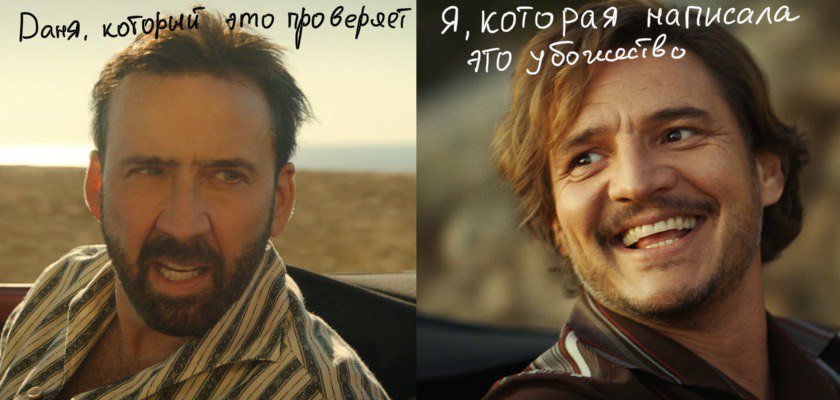

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [45]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)
        

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [48]:
class FCNet_custom(nn.Module):
    def __init__(self, activation=CustomReLU()):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation

    def forward(self, x): 
        x = x.view(-1, 784) 
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [51]:
n_epochs = 10
loss_history = []
fc_net = FCNet_custom()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad() # Обнуляем градиенты
        outputs = fc_net(images) # Прогоняем данные через сеть и получаем предсказания
        loss = loss_function(outputs, labels) # Рассчитываем функцию потерь
        loss.backward() # Рассчитываем градиенты
        optimizer.step() # Обновляем веса
    # Метрики после каждой эпохи
    train_accuracy = get_accuracy(fc_net, trainloader)
    test_accuracy = get_accuracy(fc_net, testloader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

final_test_accuracy = get_accuracy(fc_net, testloader)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch 1/10, Train Accuracy: 0.8921, Test Accuracy: 0.7757
Epoch 2/10, Train Accuracy: 0.9271, Test Accuracy: 0.8234
Epoch 3/10, Train Accuracy: 0.9487, Test Accuracy: 0.8491
Epoch 4/10, Train Accuracy: 0.9612, Test Accuracy: 0.8693
Epoch 5/10, Train Accuracy: 0.9709, Test Accuracy: 0.8781
Epoch 6/10, Train Accuracy: 0.9758, Test Accuracy: 0.8840
Epoch 7/10, Train Accuracy: 0.9833, Test Accuracy: 0.8916
Epoch 8/10, Train Accuracy: 0.9861, Test Accuracy: 0.8946
Epoch 9/10, Train Accuracy: 0.9905, Test Accuracy: 0.8963
Epoch 10/10, Train Accuracy: 0.9921, Test Accuracy: 0.8921
Final Test Accuracy: 0.8921


Сравним с оригиналом:

In [53]:
n_epochs = 10
loss_history = []
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad() # Обнуляем градиенты
        outputs = fc_net(images) # Прогоняем данные через сеть и получаем предсказания
        loss = loss_function(outputs, labels) # Рассчитываем функцию потерь
        loss.backward() # Рассчитываем градиенты
        optimizer.step() # Обновляем веса
    # Метрики после каждой эпохи
    train_accuracy = get_accuracy(fc_net, trainloader)
    test_accuracy = get_accuracy(fc_net, testloader)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

final_test_accuracy = get_accuracy(fc_net, testloader)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Epoch 1/10, Train Accuracy: 0.8975, Test Accuracy: 0.7803
Epoch 2/10, Train Accuracy: 0.9299, Test Accuracy: 0.8259
Epoch 3/10, Train Accuracy: 0.9470, Test Accuracy: 0.8469
Epoch 4/10, Train Accuracy: 0.9606, Test Accuracy: 0.8700
Epoch 5/10, Train Accuracy: 0.9697, Test Accuracy: 0.8792
Epoch 6/10, Train Accuracy: 0.9769, Test Accuracy: 0.8857
Epoch 7/10, Train Accuracy: 0.9816, Test Accuracy: 0.8902
Epoch 8/10, Train Accuracy: 0.9870, Test Accuracy: 0.8915
Epoch 9/10, Train Accuracy: 0.9899, Test Accuracy: 0.8957
Epoch 10/10, Train Accuracy: 0.9925, Test Accuracy: 0.8955
Final Test Accuracy: 0.8955


Хе-хе, мое даже лучше, но возможно я использовала запрещенный прием

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

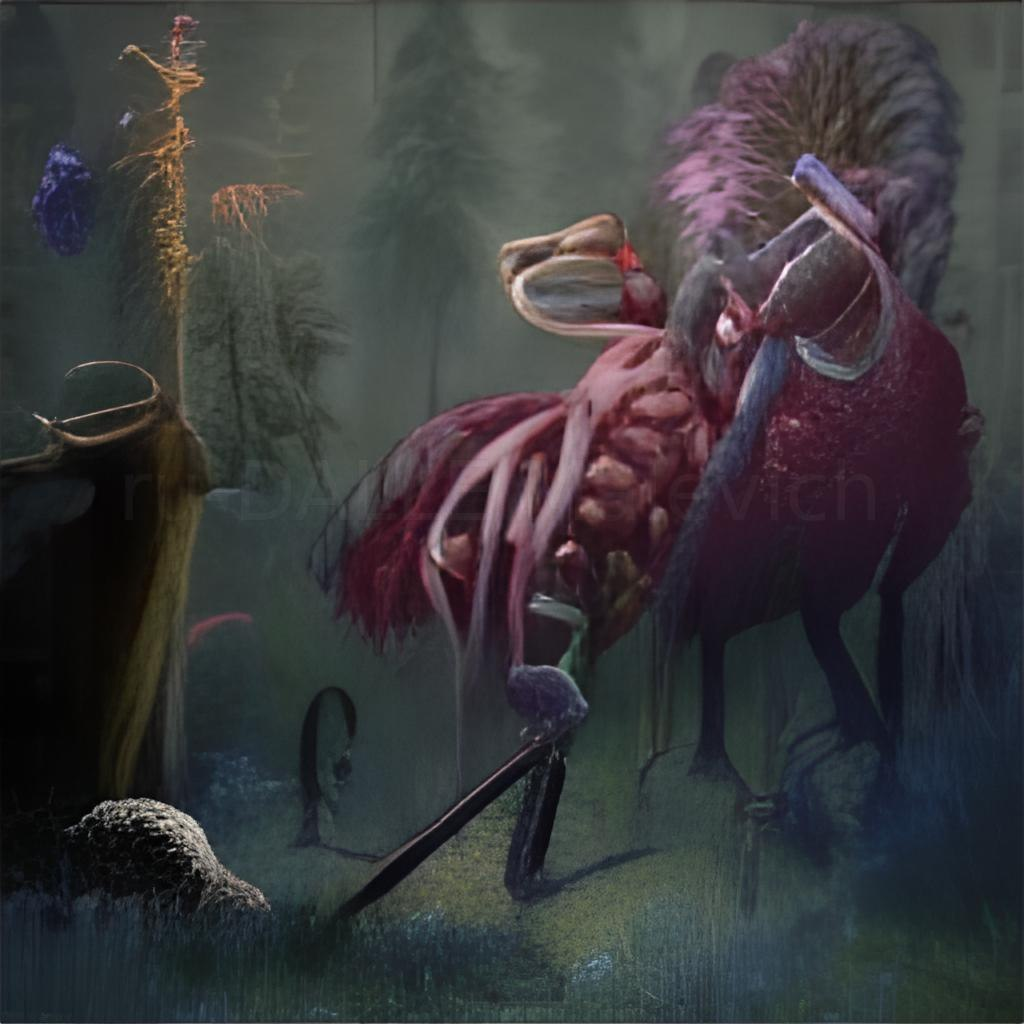

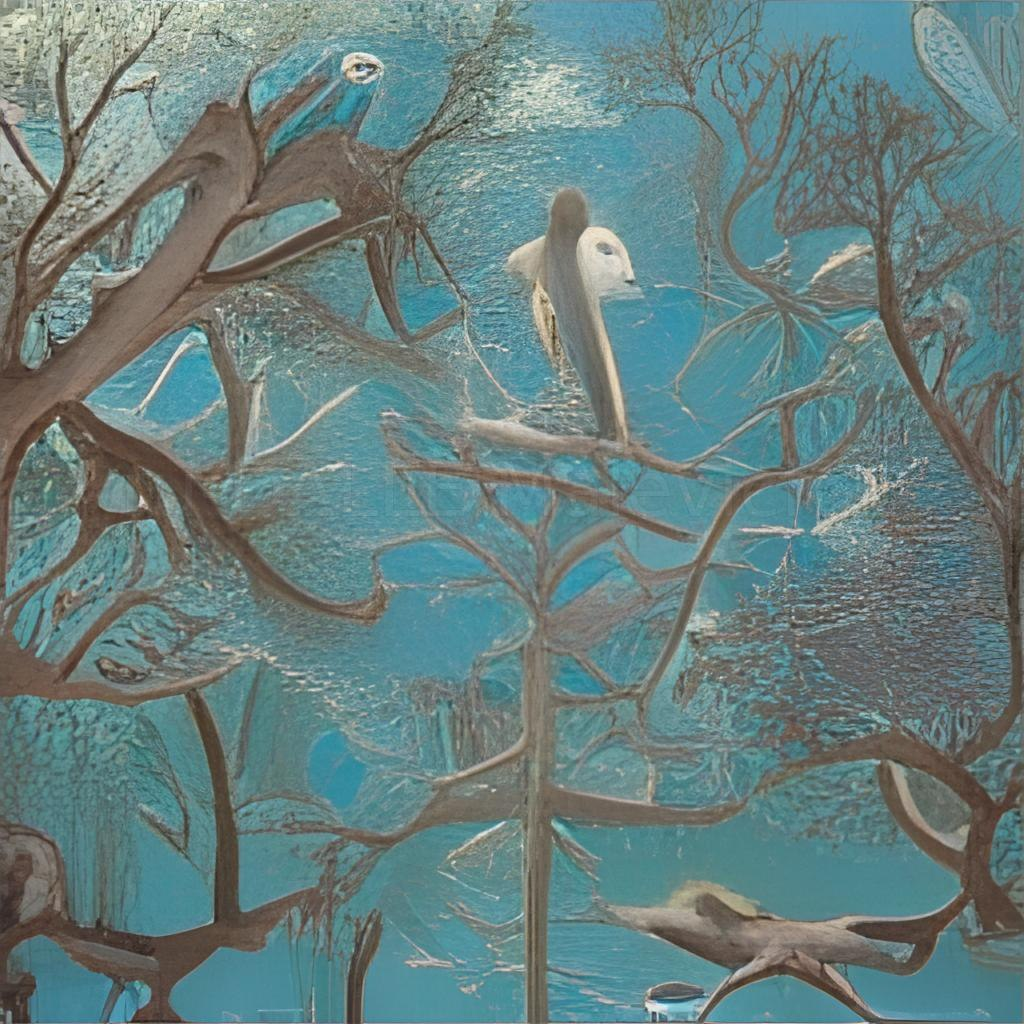

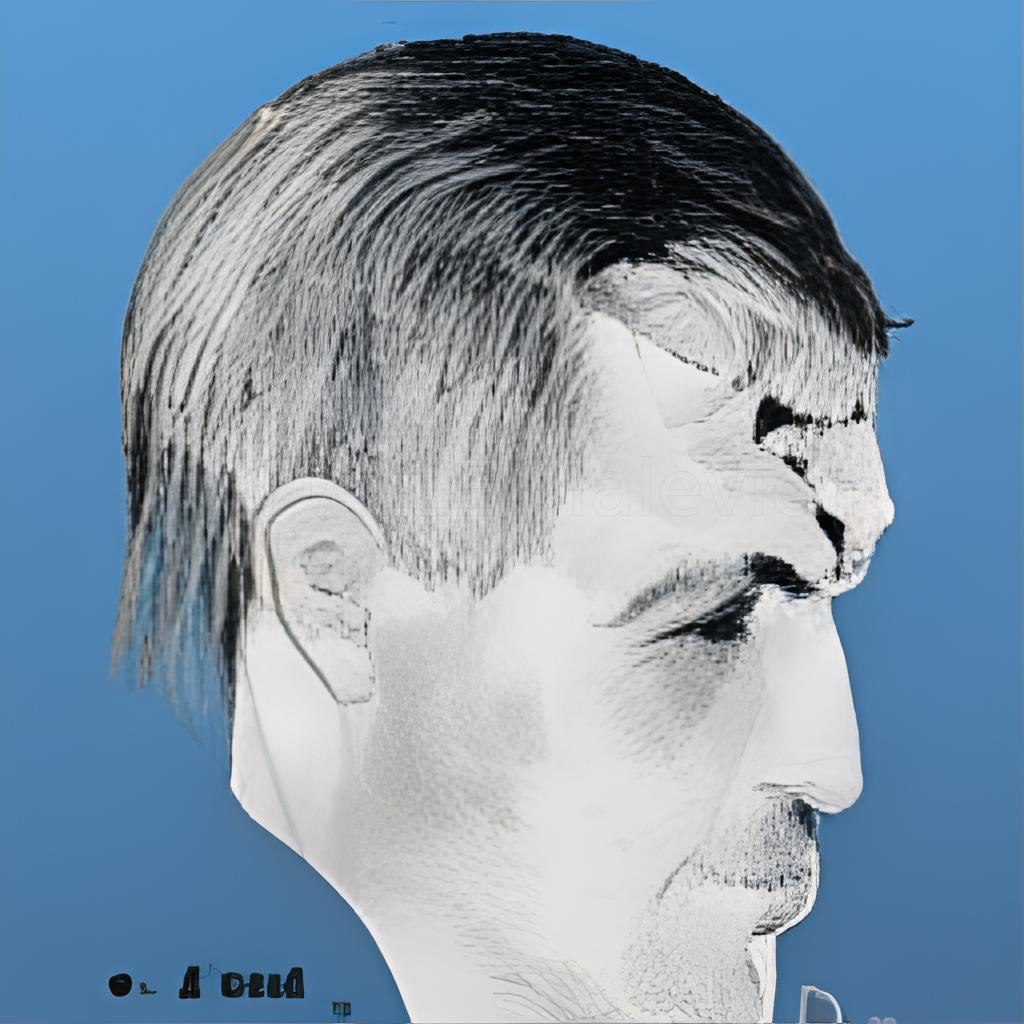